In [1]:
import numpy as np
import pandas as pd

from pm4py.algo.simulation.tree_generator import factory as tree_gen_factory
from pm4py.objects.process_tree import semantics
from pm4py.visualization.process_tree import factory as pt_vis_factory
from pm4py.objects.conversion.process_tree import factory as pt_conv_factory
from pm4py.visualization.petrinet import factory as pn_vis_factory
from pm4py.algo.discovery.inductive import factory as inductive_miner
from pm4py.algo.discovery.alpha import factory as alpha_miner
from pm4py.objects.log.exporter.xes import factory as xes_exporter
from pm4py.objects.conversion.log import factory as conversion_factory

Choose parameters for the Process Tree

In [2]:
filenamepetrinet = "PN-10.pnml"
filenameGTlog = "GTlog-10.xes"

In [3]:
mode = 30
minimum = 15
maximum = 45
sequence = 0.75
choice = 0.0
parallel = 0.25
loops = 0.0

In [4]:
parameters = {"mode": mode, "min": minimum, "max": maximum, "sequence": sequence, "choice": choice, "parallel": parallel, "loop": loops}

Generate the process tree with a minimum average trace size

In [5]:
def get_average(list):
    av = []
    for trace in list:
        av.append(len(trace))
    return sum(av) / len(av) 

In [6]:
def gen_tree(sizelog, parameters, minimumlength):
    print(parameters)
    av_num_traces = 0.0
    smallesttrace = 0.0
    while av_num_traces < minimumlength/2 and smallesttrace<4.0:
        tree = tree_gen_factory.apply(parameters=parameters)
        log = semantics.generate_log(tree, no_traces=sizelog)
        av_num_traces = get_average(log)
        smallesttrace = min(map(len, log))
        print(smallesttrace)
    print(av_num_traces)
    return log, tree

In [21]:
log, tree = gen_tree(1000, parameters, minimum)

{'mode': 30, 'min': 15, 'max': 45, 'sequence': 0.75, 'choice': 0.0, 'parallel': 0.25, 'loop': 0.0, 'or': 0.0, 'silent': 0.2, 'duplicate': 0, 'lt_depencency': 0.0, 'infrequent': 0.5, 'no_models': 10, 'unfold': 10, 'max_repeat': 10}
20
20.0


In [22]:
print(tree)

->( ->( ->( ->( a, +( h, ->( i, +( j, m ) ) ) ), g ), ->( ->( f, ->( o, r ) ), k ) ), ->( +( ->( b, s ), l ), ->( ->( c, q ), ->( ->( d, p ), ->( +( e, t ), n ) ) ) ) )


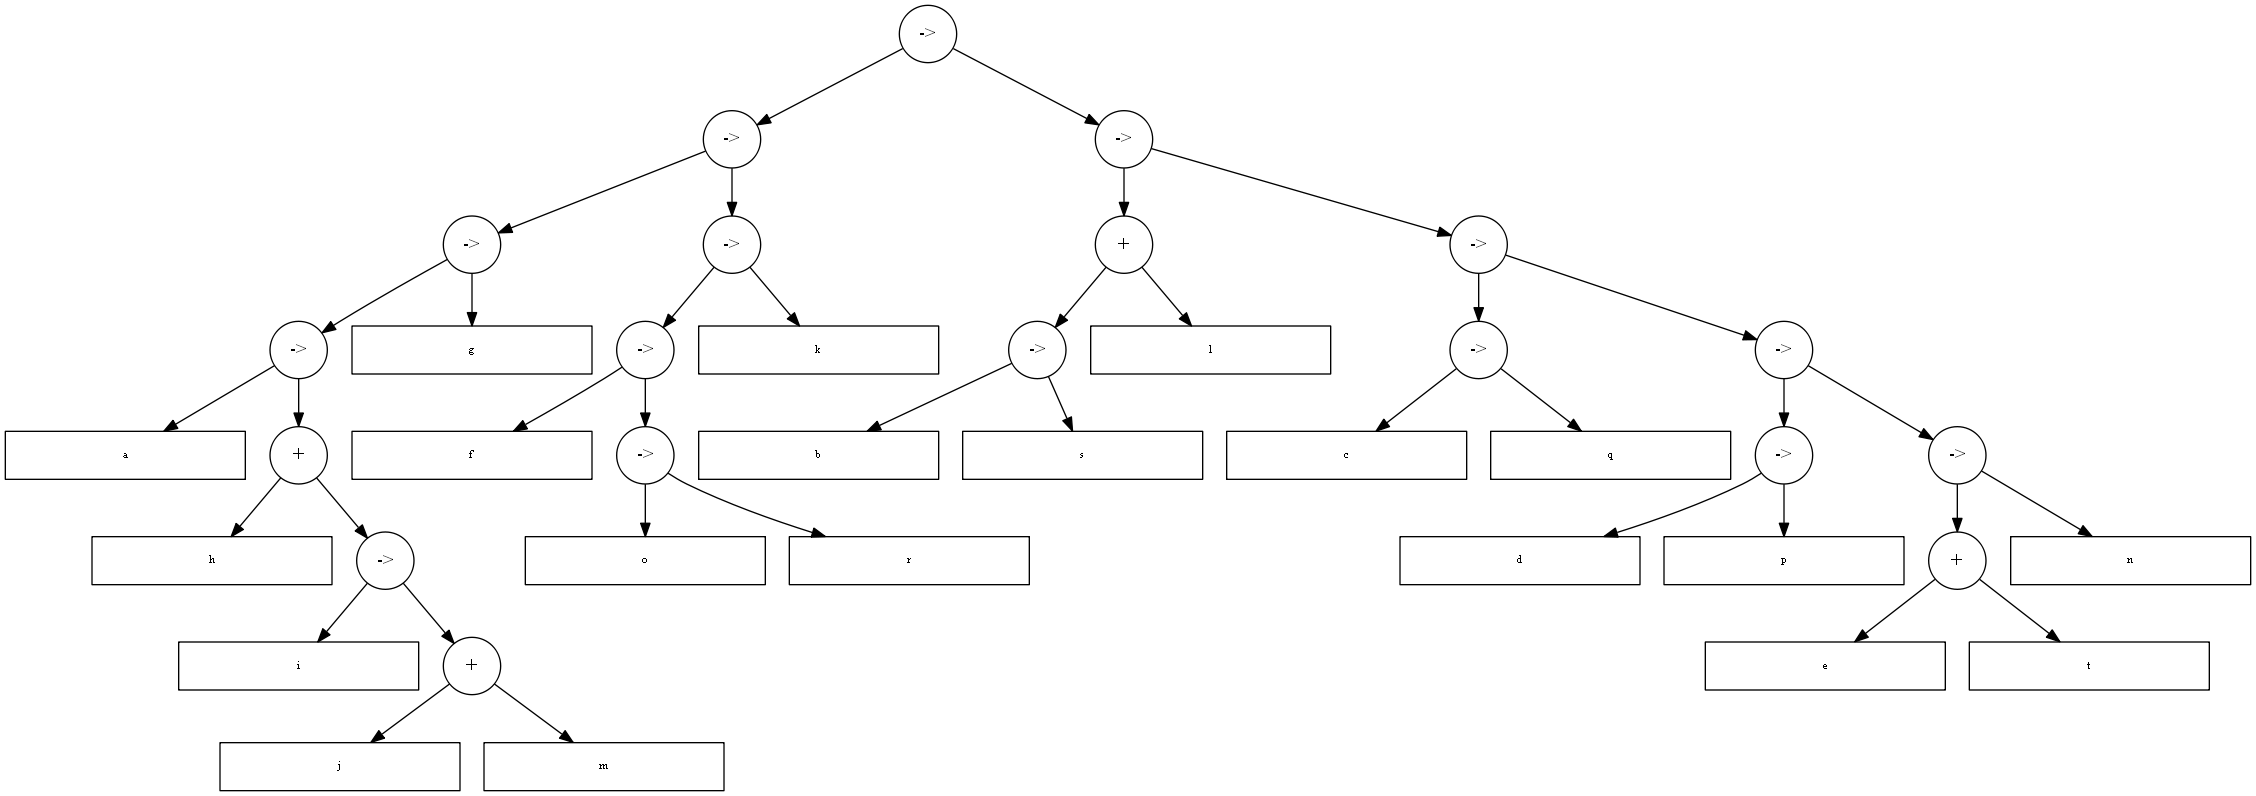

In [23]:
gviz = pt_vis_factory.apply(tree, parameters={"format": "png"})
pt_vis_factory.view(gviz)

In [24]:
net, im, fm = pt_conv_factory.apply(tree)

In [25]:
gviz = pn_vis_factory.apply(net, im, fm)

In [26]:
from pm4py.objects.petri.exporter import pnml as pnml_exporter
pnml_exporter.export_net(net, im, filenamepetrinet)

C:\Users\u0132580\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function export_net.
  


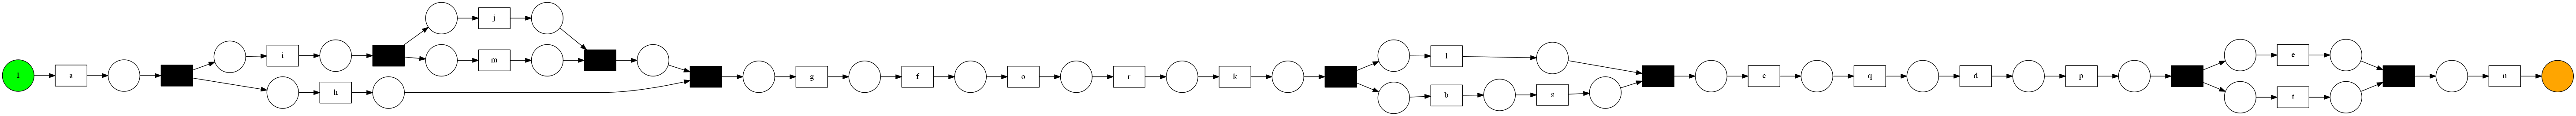

In [27]:
pn_vis_factory.view(gviz)

In [28]:
from py4j.java_gateway import JavaGateway
from collections import deque

class OutputGetter(deque):
    def appendleft(self, line):
        print(line)
        super().appendleft(line)

gateway = JavaGateway.launch_gateway(classpath="./jars/*", 
                                     redirect_stdout=OutputGetter())
petri_and_marking = gateway.jvm.org.processmining.plugins.kutoolbox.utils.ImportUtils.openPetrinet(
    gateway.jvm.java.io.File(filenamepetrinet)
)
if not petri_and_marking[1].size():
    print("Creating initial marking")
    petri_and_marking[1] = gateway.jvm.org.processmining.plugins.kutoolbox.utils.PetrinetUtils. \
        getInitialMarking(petri_and_marking[0])
    
petri_and_marking[1].size()
settings = gateway.jvm.org.processmining.plugins.loggenerator.utils.GeneratorSettings()
simulator = gateway.jvm.org.processmining.plugins.loggenerator.utils.GeneratorSettings.SimulationAlgorithm

# See https://github.com/Macuyiko/processmining-prom/blob/master/loggenerator/
#             org/processmining/plugins/loggenerator/utils/GeneratorSettings.java

for t in petri_and_marking[0].getTransitions().iterator():
    isInvisible = t.getLabel() == "" or t.isInvisible()
    label = t.getLabel()
    isTextInvisible = label.startswith("inv_") or "$" in label
    mapped = label.replace("+complete", "").replace("\\ncomplete", "").replace("\\n", "") \
        if not isInvisible and not isTextInvisible else ""
    arr = gateway.new_array(gateway.jvm.int, 4)
    arr[0], arr[1], arr[2], arr[3] = 60, 0, 60, 0
    settings.getTransitionNames().put(t, mapped)
    settings.getTransitionWeights().put(t, 10)
    settings.getTransitionTimings().put(t, arr)
    print(t.getId(), ':', label, '--->', mapped)
    
    settings.setNrTraces(1000)
    settings.setRandomMinInGroup(1)
    settings.setRandomMaxInGroup(1)
    settings.setMustReachEnd(True)
    settings.setMustConsumeAll(False)
    settings.setMaxTimesMarkingSeen(3)
    
    settings.setSimulationMethod(simulator.Random) # Random, Complete, or Distinct
    
    # settings.setRestartAfter(1000)
    # settings.setSkipChance(0.85)
    # settings.setAlsoConsiderPartial(False)
xlog = gateway.jvm.org.processmining.plugins.loggenerator.PetriNetLogGenerator.generate(
    petri_and_marking[0], 
    petri_and_marking[1], 
    settings, 
    #None # or for output: gateway.jvm.org.processmining.plugins.kutoolbox.eventlisteners.PluginEventListenerCLI()
    gateway.jvm.org.processmining.plugins.kutoolbox.eventlisteners.PluginEventListenerCLI()
)

GT_log1 = []
for trace in xlog:
    #print([gateway.jvm.org.deckfour.xes.extension.std.XConceptExtension.instance().extractName(e) for e in trace])
    GT_log1.append([gateway.jvm.org.deckfour.xes.extension.std.XConceptExtension.instance().extractName(e) for e in trace])

C:\Users\u0132580\AppData\Local\Continuum\anaconda3\lib\site-packages\py4j\java_collections.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import (


node c0aa5521-b410-4368-8632-48255805de57 : m ---> m
node b46bc0d7-4e34-44d5-b35f-0ecef311c2d2 : h ---> h
node da021d2b-3659-4e36-8804-1691c6aa9186 : tauJoin_2 ---> 
node 8c1c1b08-4232-47e2-8e19-7396ae45410d : b ---> b
node 1c906842-37c8-41d8-9f30-828f0bcc7e65 : tauSplit_1 ---> 
node c6d1460f-f990-4084-994a-b6927ca636b7 : tauSplit_7 ---> 
node 88e96b32-389a-4bfa-854f-cec42996d1f3 : g ---> g
node e954780e-f446-4e16-bcc1-a2824df963f8 : tauJoin_8 ---> 
node 75bc4a4a-c5c8-4f9b-bef8-ad996960fd12 : s ---> s
node 5f4c4f9f-d00a-4b67-8cab-6e577bbe6df1 : n ---> n
node f799ee06-6167-4785-8970-58fe84755cbd : f ---> f
node 18b08276-8df6-48f0-a661-b5dae95a84c7 : i ---> i
node 81249f13-7c41-4ef5-8c95-e1cb1ffd2364 : o ---> o
node a320daab-f877-4cf1-a6de-28abc2073544 : e ---> e
node a945253c-a1ec-4d9b-9e44-3cf29cafa3f2 : l ---> l
node 0389019e-4551-438b-801b-6e42e831fdd0 : tauSplit_3 ---> 
node 721572e5-64c1-4ef4-9efb-cad5352d3dad : r ---> r
node 5f208d5d-eb78-41a3-bc15-8ca776396c6f : tauJoin_4 ---> 
n

In [29]:
GT_log = []

for trace in GT_log1:
    newtrace = trace[::2]
    GT_log.append(newtrace)

In [30]:
def list_to_df(logdummy):
    df = pd.DataFrame(columns=['Activity', 'case:concept:name', 'concept:name'])
    for i in range(0,len(logdummy)):
        for activity in logdummy[i]:
            row = [activity, str(i), activity]
            df.loc[len(df)] = row
    return df

In [31]:
dataframe = list_to_df(GT_log)

In [32]:
xeslog = conversion_factory.apply(dataframe)

In [33]:
xes_exporter.export_log(xeslog, filenameGTlog)

In [34]:
from pm4py.algo.discovery.alpha import factory as alpha_miner
net, initial_marking, final_marking = alpha_miner.apply(xeslog)

In [35]:
gviz = pn_vis_factory.apply(net, im, fm)

In [36]:
from pm4py.objects.petri.exporter import pnml as pnml_exporter
pnml_exporter.export_net(net, initial_marking, "alpha-10.pnml")

C:\Users\u0132580\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function export_net.
  


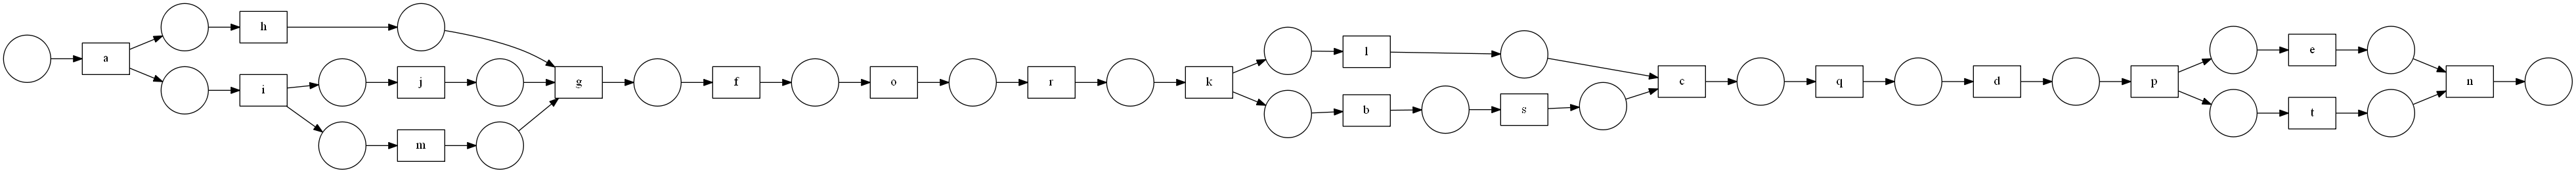

In [37]:
pn_vis_factory.view(gviz)

test alpha

In [38]:
from py4j.java_gateway import JavaGateway
from collections import deque

class OutputGetter(deque):
    def appendleft(self, line):
        print(line)
        super().appendleft(line)

gateway = JavaGateway.launch_gateway(classpath="./jars/*", 
                                     redirect_stdout=OutputGetter())
petri_and_marking = gateway.jvm.org.processmining.plugins.kutoolbox.utils.ImportUtils.openPetrinet(
    gateway.jvm.java.io.File("alpha-10.pnml")
)
if not petri_and_marking[1].size():
    print("Creating initial marking")
    petri_and_marking[1] = gateway.jvm.org.processmining.plugins.kutoolbox.utils.PetrinetUtils. \
        getInitialMarking(petri_and_marking[0])
    
petri_and_marking[1].size()
settings = gateway.jvm.org.processmining.plugins.loggenerator.utils.GeneratorSettings()
simulator = gateway.jvm.org.processmining.plugins.loggenerator.utils.GeneratorSettings.SimulationAlgorithm

# See https://github.com/Macuyiko/processmining-prom/blob/master/loggenerator/
#             org/processmining/plugins/loggenerator/utils/GeneratorSettings.java

for t in petri_and_marking[0].getTransitions().iterator():
    isInvisible = t.getLabel() == "" or t.isInvisible()
    label = t.getLabel()
    isTextInvisible = label.startswith("inv_") or "$" in label
    mapped = label.replace("+complete", "").replace("\\ncomplete", "").replace("\\n", "") \
        if not isInvisible and not isTextInvisible else ""
    arr = gateway.new_array(gateway.jvm.int, 4)
    arr[0], arr[1], arr[2], arr[3] = 60, 0, 60, 0
    settings.getTransitionNames().put(t, mapped)
    settings.getTransitionWeights().put(t, 10)
    settings.getTransitionTimings().put(t, arr)
    print(t.getId(), ':', label, '--->', mapped)
    
    settings.setNrTraces(1000)
    settings.setRandomMinInGroup(1)
    settings.setRandomMaxInGroup(1)
    settings.setMustReachEnd(True)
    settings.setMustConsumeAll(False)
    settings.setMaxTimesMarkingSeen(3)
    
    settings.setSimulationMethod(simulator.Random) # Random, Complete, or Distinct
    
    # settings.setRestartAfter(1000)
    # settings.setSkipChance(0.85)
    # settings.setAlsoConsiderPartial(False)
xlog = gateway.jvm.org.processmining.plugins.loggenerator.PetriNetLogGenerator.generate(
    petri_and_marking[0], 
    petri_and_marking[1], 
    settings, 
    #None # or for output: gateway.jvm.org.processmining.plugins.kutoolbox.eventlisteners.PluginEventListenerCLI()
    gateway.jvm.org.processmining.plugins.kutoolbox.eventlisteners.PluginEventListenerCLI()
)

GT_log1 = []
for trace in xlog:
    #print([gateway.jvm.org.deckfour.xes.extension.std.XConceptExtension.instance().extractName(e) for e in trace])
    GT_log1.append([gateway.jvm.org.deckfour.xes.extension.std.XConceptExtension.instance().extractName(e) for e in trace])

node d6394d68-3c13-4031-8727-e067c4213772 : r ---> r
node b6a5babf-84c1-4c42-a580-dbf3f303f5cb : h ---> h
node 72481b46-3f4b-41fa-80ed-59de7117dcae : d ---> d
node 86cc0f55-3382-43c4-a3c3-c0568dd75240 : f ---> f
node 1fac5fc2-889a-4c8b-baba-cfe9013aa266 : n ---> n
node 4f1e23d6-9de5-43ae-8c90-c26fcc3d5c3d : g ---> g
node 30153f1e-10e8-4e78-92ab-ae6417bfbee0 : o ---> o
node 591a19cb-f2d7-4121-9ea1-c6272d08e6ef : m ---> m
node 05b7d53a-14d1-486c-b248-44d115e21349 : p ---> p
node deb36a74-59d7-4f77-9fb3-d0d66e1a2227 : t ---> t
node 3d180cb0-79e1-4224-be84-a11a15bd34fd : j ---> j
node ff3d1975-e42c-49dc-bf27-315534ee7fbc : a ---> a
node b4abb9a0-7831-4468-804b-b61ad79effff : k ---> k
node 50a9cbf4-8bc1-4a8c-ab0c-31a8038bf842 : i ---> i
node f33ffb12-8707-40cc-9ec4-a9ec855289dd : s ---> s
node f8be181e-7dba-4dcf-bd6c-07fcd52d07d9 : e ---> e
node beee3688-03e8-4ec7-9586-f1f38476904b : q ---> q
node 2251d35e-55d9-4ecb-a94e-4d0f0da0f512 : l ---> l
node 25dca6f2-4ac8-434c-84cb-55927d2c01fc : b 

In [ ]:
print(GT_log1)